#### In the sliding window approach, an inspection window is passed over an image to select a patch and classify each image patch covered by the window using the object recognition model. It is an exhaustive search for objects over the entire image. Not only do we need to search all possible locations in the image, we have to search at different scales. This is because object recognition models are generally trained at a specific scale (or range of scales). This results into classifying tens of thousands of image patches.

#### Region proposal algorithms identify prospective objects in an image using segmentation. In segmentation approaches, group adjacent regions which are similar to each other based on some criteria such as color, texture etc. Unlike the sliding window approach where we are looking for the object at all pixel locations and at all scales, region proposal algorithm work by grouping pixels into a smaller number of segments. The final number of proposals generated are many times less than sliding window approach. This reduces the number of image patches we have to classify. These generated region proposals are of different scales and aspect ratios.

#### Use the following OpenCV support function to evaluate selective search in comparison to windowing algorithms. An associated Jupyter notebook has been included and reviewed during lecture. There are two modes for the OpenCV selective search: “fast” and “quality”. Fast- generates region proposals in a faster method and quality generates more region proposals. For the sample image beagle.png



######  Code a for a windowing approach to dividing the input image into a list of roi and respective boxes. The function should return the rois and boxes similar to above. The input of the windowing system will evaluate fixed size windows that take on the evaluation window of (WxW) with a stride of S. Stride is how many pixel positions does the window slide after a selection. A window will move across the width of an image +S. After the window moves from the left to the right of an image, the next row evaluated will be +S away. In this way, S=1 will evaluate every window WxW in the entire image.

In [1]:
# import the necessary packages
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.preprocessing.image import img_to_array

from imutils.object_detection import non_max_suppression

import numpy as np
import argparse
import imutils
import time
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import pprint

#Push physical devices list for GPU 
physical_devices = tf.config.list_physical_devices('GPU')
try:
# Disable all GPUS
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != 'GPU'
except:
# Invalid device or cannot modify virtual devices once initialized.
    pass

In [2]:
# Def sliding window for Region proposal algorithms
def window(image, stepsize, win_sliding):
    # code sequence for a windowing approach to dividing the input image into a list of roi and respective boxes
    for y in range(0, image.shape[0] - win_sliding[1], stepsize):
        for x in range(0, image.shape[1] - win_sliding[0], stepsize):
            # get current window
            yield (x, y, image[y:y + win_sliding[1], x:x + win_sliding[0]])
# Def image loop for Region proposal algorithms            
def image_loop(image, scale=1.5, minSize=(224, 224)):
    # get original image
    yield image
    # keep looping over the image loop 
    while True:
        # compute the dimensions of the next image in the looping methoud 
        w = int(image.shape[1] / scale)
        image = imutils.resize(image, width=w)
        # brek loop if new image does not == supplied minimum size
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        # get the next image in the loop
        yield image

# Set args for part A (Using test but beagle is available)
args = dict()
args['image'] = 'test.jpg'  # 'test.jpg'    'beagle.png'
args['method'] = 'fast'   # Other choice is quality
args['conf'] = 0.9
args['filter'] = None
# Set scaling args
WIDTH = 600
SCALE = 1.5
WINDOW_STEP = 8
ROI_SIZE = (128, 128) 
INPUT_SIZE = (224, 224)

In [3]:
# load our network weights from disk
print("[INFO] loading network...")
model = ResNet50(weights="imagenet", include_top=True)
# load the input image from disk, resize it such that it has the
# has the supplied width, and then grab its dimensions
img = cv2.imread(args["image"])
img = imutils.resize(img, width=WIDTH)
(H, W) = img.shape[:2]

[INFO] loading network...


In [4]:
image_loop_yield= image_loop(img, scale=SCALE, minSize=ROI_SIZE)
#Define roi's and loacl bounds found 
rois = []
locs = []

start = cv2.getTickFrequency()   # Set clock for run time
# Go to window sliding Region proposal algorithms 
def window_sliding(image_loop_yield,WINDOW_STEP, ROI_SIZE):
    # Set local roi's and loacl bounds found to push to main 
    rois = []
    locs = []
    for image in image_loop_yield:    # loop over images to yeild dimensions of the next image in the looping methoud       
        scale = W / float(image.shape[1])
        for (x, y, roiOrig) in window(image, WINDOW_STEP, ROI_SIZE): # Go to slide window for dividing the input                               
            x = int(x * scale)                                       #image into a list of roi and respective boxes
            y = int(y * scale)        # Set scaling for window
            w = int(ROI_SIZE[0] * scale)
            h = int(ROI_SIZE[1] * scale)
            roi = cv2.resize(roiOrig, INPUT_SIZE)  # read roi 
            roi = img_to_array(roi)
            roi = preprocess_input(roi)  
            rois.append(roi)           # push locals and bounds to main 
            locs.append((x, y, x + w, y + h))
    return rois, locs
end = cv2.getTickFrequency()

rois, locs =  window_sliding(image_loop_yield, WINDOW_STEP, ROI_SIZE)   
time = (end  - start)/ cv2.getTickFrequency()

proposals = np.array(rois)                                     # shape proposals and print out time and format 
print("[INFO] proposal shape: {}".format(proposals.shape))
print( time, "seconds")      

[INFO] proposal shape: (2726, 224, 224, 3)
0.0 seconds


In [5]:
# proposals filter set
labelFilters = args["filter"]
if labelFilters is not None:
    labelFilters = labelFilters.lower().split(",")
print("[INFO] loading ResNet...")
# ResNet50 load 
model = ResNet50(weights="imagenet")
print("[INFO] classifying proposals...")
preds = model.predict(proposals)
preds = imagenet_utils.decode_predictions(preds, top=1)

[INFO] loading ResNet...
[INFO] classifying proposals...


In [6]:
labels = {} # empty list for main computation 
# Def sequence as a separate function to be used after predictions are made
def pred_made(preds, confidence, local):
    labelFilters = ['beagle']
    labels = {}
    # loop over the predictions
    for (i, p) in enumerate(preds):
        # grab the prediction information for the current ROI
        (imagenetID, label, prob) = p[0]
        #print (label) # DEBUG 
        if labelFilters is not None and label not in labelFilters:
            continue
        # filter out weak detections by ensuring the predicted probability
        # is greater than the minimum probability
        if prob >= confidence:
            # grab the bounding box associated with the prediction and
            # convert the coordinates
            box = local[i]
            # grab the list of predictions for the label and add the
            # bounding box and probability to the list
            L = labels.get(label, [])
            L.append((box, prob))
            labels[label] = L               
    return labels

labels = pred_made(preds, args['conf'], locs) 
#print(labels) # DEBUG 

In [7]:
proposals_image = img.copy()
annotated_image = img.copy()

# loop over the labels for each of detected objects in the image
for label in labels.keys():
    # clone the original image so that we can draw on it
    print("[INFO] showing results for '{}'".format(label))

    # loop over all bounding boxes for the current label
    for (box, prob) in labels[label]:
        # draw the bounding box on the image
        (startX, startY, endX, endY) = box
        cv2.rectangle(proposals_image, (startX, startY), (endX, endY),
            (0, 255, 0), 2)

    # extract the bounding boxes and associated prediction
    # probabilities, then apply non-maxima suppression
    boxes = np.array([p[0] for p in labels[label]])
    proba = np.array([p[1] for p in labels[label]])
    boxes = non_max_suppression(boxes, proba)
    # loop over all bounding boxes that were kept after applying
    # non-maxima suppression
    for (startX, startY, endX, endY) in boxes:
        # draw the bounding box and label on the image
        cv2.rectangle(annotated_image, (startX, startY), (endX, endY),
            (0, 255, 0), 2)
        y = startY - 10 if startY - 10 > 10 else startY + 10
        cv2.putText(annotated_image , label, (startX, y),
            cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)

[INFO] showing results for 'beagle'


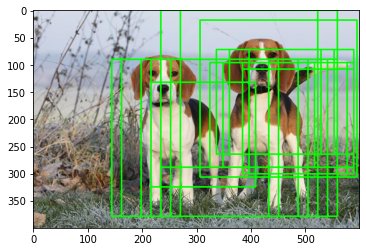

In [8]:
plt.imshow(cv2.cvtColor(proposals_image, cv2.COLOR_BGR2RGB))

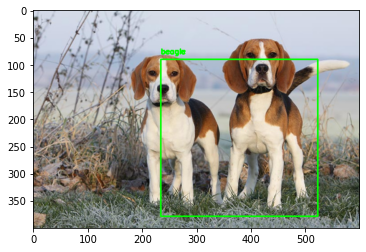

In [9]:
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))

##### Evaluate the window and region proposal approaches to understand count. Plot a graph for WxW=128, for S=[1,2,4,8,16,32]. The code should report the findings of how many windows per each of the 6 settings compared to the fast/quality evaluation of the region proposal system.  A test image called test.png is provided. 

In [11]:
#Plot a graph for WxW=128, for S=[1,2,4,8,16,32]. 
#The code should report the findings of how many windows per each of the 6 settings
#compared to the fast/quality evaluation of the region proposal system.  
# load our network weights from disk
print("[INFO] loading network...")
model = ResNet50(weights="imagenet", include_top=True)
# load the input image from disk, resize it such that it has the
# has the supplied width, and then grab its dimensions
img = cv2.imread(args["image"])
img = imutils.resize(img, width=WIDTH)
(H, W) = img.shape[:2]

image_loop_yield= image_loop(img, scale=SCALE, minSize=ROI_SIZE)

WINDOW_STEP2 = 2
WINDOW_STEP4 = 4
WINDOW_STEP8 = 8
WINDOW_STEP16 = 16
WINDOW_STEP32 = 32
ROI_SIZE_TEST = (128, 128) 

rois2, rois4, rois8, rois16, rois32 = [], [], [], [], []
locs2, locs4, locs8, locs16, locs32 = [], [], [], [], []

start2 = cv2.getTickCount()
rois2, locs2 =  window_sliding(image_loop_yield, WINDOW_STEP2, ROI_SIZE_TEST)
end2 = cv2.getTickCount()
time2 = (end2  - start2)/ cv2.getTickFrequency()
proposals2 = np.array(rois2)


[INFO] loading network...


In [ ]:
print("[INFO] loading network...")
model = ResNet50(weights="imagenet", include_top=True)
# load the input image from disk, resize it such that it has the
# has the supplied width, and then grab its dimensions
img = cv2.imread(args["image"])
img = imutils.resize(img, width=WIDTH)
(H, W) = img.shape[:2]

image_loop_yield= image_loop(img, scale=SCALE, minSize=ROI_SIZE)

start4 = cv2.getTickCount()
rois4, locs4 =  window_sliding(image_loop_yield, WINDOW_STEP4, ROI_SIZE_TEST)   
end4 = cv2.getTickCount()
time4 = (end4  - start4)/ cv2.getTickFrequency()
proposals4 = np.array(rois4)

[INFO] loading network...


In [ ]:
print("[INFO] loading network...")
model = ResNet50(weights="imagenet", include_top=True)
# load the input image from disk, resize it such that it has the
# has the supplied width, and then grab its dimensions
img = cv2.imread(args["image"])
img = imutils.resize(img, width=WIDTH)
(H, W) = img.shape[:2]

image_loop_yield= image_loop(img, scale=SCALE, minSize=ROI_SIZE)

start8 = cv2.getTickCount()
rois8, locs8 =  window_sliding(image_loop_yield, WINDOW_STEP8, ROI_SIZE_TEST)  
end8 = cv2.getTickCount()
time8 = (end8  - start8)/ cv2.getTickFrequency()
proposals8 = np.array(rois8)

In [ ]:
print("[INFO] loading network...")
model = ResNet50(weights="imagenet", include_top=True)
# load the input image from disk, resize it such that it has the
# has the supplied width, and then grab its dimensions
img = cv2.imread(args["image"])
img = imutils.resize(img, width=WIDTH)
(H, W) = img.shape[:2]

image_loop_yield= image_loop(img, scale=SCALE, minSize=ROI_SIZE)

start16 = cv2.getTickCount()
rois16, locs16 =  window_sliding(image_loop_yield, WINDOW_STEP16, ROI_SIZE_TEST)  
end16 = cv2.getTickCount()
time16 = (end16  - start16)/ cv2.getTickFrequency()
proposals16 = np.array(rois16)

In [ ]:
print("[INFO] loading network...")
model = ResNet50(weights="imagenet", include_top=True)
# load the input image from disk, resize it such that it has the
# has the supplied width, and then grab its dimensions
img = cv2.imread(args["image"])
img = imutils.resize(img, width=WIDTH)
(H, W) = img.shape[:2]

image_loop_yield= image_loop(img, scale=SCALE, minSize=ROI_SIZE)

start32 = cv2.getTickCount()
rois32, locs32 =  window_sliding(image_loop_yield, WINDOW_STEP32, ROI_SIZE_TEST)   
end32 = cv2.getTickCount()
time32 = (end32  - start32)/ cv2.getTickFrequency()
proposals32 = np.array(rois32)

In [ ]:
#Print out all obtains times
print("[INFO] proposal shape at window slide of 2: {}".format(proposals2.shape))
print( time2, "seconds")
print("[INFO] proposal shape at window slide of 4: {}".format(proposals4.shape))
print( time4, "seconds")
print("[INFO] proposal shape at window slide of 8: {}".format(proposals8.shape))
print( time8, "seconds")
print("[INFO] proposal shape at window slide of 16: {}".format(proposals16.shape))
print( time16, "seconds")
print("[INFO] proposal shape at window slide of 32: {}".format(proposals32.shape))
print( time32, "seconds")

In [12]:
# Scatter graph on time vs. proposals run 
graph_time = [time32,time16,time8,time4,time2]
graph_proposals = [len(proposals32),len(proposals16),len(proposals8),len(proposals4),len(proposals2)]
plt.scatter(graph_time, graph_proposals)
plt.show()

NameError: name 'time32' is not defined

#### Show a graph for the number of region proposals (and then final predictions) in which the stages of use are the following (for both fast and quality):

In [8]:
# Set args for part C (Using test but beagle is available) for testing fast vs. quality  performance 
argsF = dict()
argsF['image'] = 'test.jpg'  # 'test.jpg'    'beagle.png'
argsF['method'] = 'fast'   # Other choice is quality
argsF['conf'] = 0.9
argsF['filter'] = None
argsQ = dict()
argsQ['image'] = 'test.jpg' # 'test.jpg'    'beagle.png'
argsQ['method'] = 'quality'   # Other choice is quality
argsQ['conf'] = 0.9
argsQ['filter'] = None

In [9]:
def selective_search(image, method="fast"):
    # initialize OpenCV's selective search implementation and set the
    # input image
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)

    # check to see if we are using the *fast* but *less accurate* version
    # of selective search
    if method == "fast":
        ss.switchToSelectiveSearchFast()

    # otherwise we are using the *slower* but *more accurate* version
    else:
        ss.switchToSelectiveSearchQuality()

    # run selective search on the input image
    rects = ss.process()

    # return the region proposal bounding boxes
    return rects

In [10]:
argsF['method'] = 'fast'   # Other choice is quality
argsQ['method'] = 'quality'   # Other choice is fast
# load the input image from disk and grab its dimensions
imageF = cv2.imread(argsF['image'])
(HF, WF) = imageF.shape[:2]

imageQ = cv2.imread(argsQ['image'])
(HQ, WQ) = imageQ.shape[:2]

In [11]:
###################### run selective search on the input image fast ######################
print("We are running on Fast selective search")
print("[INFO] performing selective search with '{}' method...".format(
    argsF["method"]))
e1F = cv2.getTickCount()
rectsF = selective_search(imageF, method=argsF["method"])
e2F = cv2.getTickCount()
timeF = (e2F - e1F)/ cv2.getTickFrequency()
print( timeF, "seconds")
print("[INFO] {} regions found by selective search\n".format(len(rectsF)))

###################### run selective search on the input image quality ######################
print("We are running on Quality selective search")
print("[INFO] performing selective search with '{}' method...".format(
    argsQ["method"]))

e1Q = cv2.getTickCount()
rectsQ = selective_search(imageQ, method=argsQ["method"])
e2Q = cv2.getTickCount()

timeQ = (e2Q - e1Q)/ cv2.getTickFrequency()

print( timeQ, "seconds")
print("[INFO] {} regions found by selective search".format(len(rectsQ)))

We are running on Fast selective search
[INFO] performing selective search with 'fast' method...
2.243369581 seconds
[INFO] 2489 regions found by selective search

We are running on Quality selective search
[INFO] performing selective search with 'quality' method...
6.804774928 seconds
[INFO] 9936 regions found by selective search


In [15]:
proposalsF, proposalsQ = [], []
boxesF, boxesQ = [], []
# Def NEW selective sequence as a separate function to be used after predictions are made
def selectiv_rects(rects,image, H, W):
# initialize the list of region proposals that we'll be classifying
# along with their associated bounding boxes
    proposals = []
    boxes = []
    # loop over the region proposal bounding box coordinates generated by
    # running selective search
    for (x, y, w, h) in rects: 
        # if the width or height of the region is less than 10% of the
        # image width or height, ignore it (i.e., filter out small
        # objects that are likely false-positives)
        if w / float(W) < 0.1 or h / float(H) < 0.1:
            continue
        # extract the region from the input image, convert it from BGR to
        # RGB channel ordering, and then resize it to 224x224 (the input
        # dimensions required by our pre-trained CNN)
        roi = image[y:y + h, x:x + w]
        roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
        roi = cv2.resize(roi, (224, 224))
        # further preprocess by the ROI
        roi = img_to_array(roi)
        roi = preprocess_input(roi)
        # update our proposals and bounding boxes lists
        proposals.append(roi)
        boxes.append((x, y, w, h))                          
    return proposals, boxes
                                         
proposalsF, boxesF = selectiv_rects(rectsF, imageF, HF, WF)
proposalsF = np.array(proposalsF)
print("[INFO] proposal shape: {}".format(proposalsF.shape))

proposalsQ, boxesQ = selectiv_rects(rectsQ, imageQ, HQ, WQ)
proposalsQ = np.array(proposalsQ)
print("[INFO] proposal shape: {}".format(proposalsQ.shape))

[INFO] proposal shape: (877, 224, 224, 3)
[INFO] proposal shape: (4173, 224, 224, 3)


In [16]:
# grab the label filters command line argument
labelFiltersF = argsF["filter"]
labelFiltersQ = argsQ["filter"]

# if the label filter is not empty, break it into a list
if labelFiltersF is not None:
    labelFiltersF = labelFiltersF.lower().split(",")
if labelFiltersQ is not None:
    labelFiltersQ = labelFiltersQ.lower().split(",")
    
# load ResNet from disk (with weights pre-trained on ImageNet)
print("[INFO] loading ResNet...")
model = ResNet50(weights="imagenet")

[INFO] loading ResNet...


In [17]:
print("[INFO] classifying fast proposals...")
predsF = model.predict(proposalsF)
predsF = imagenet_utils.decode_predictions(predsF, top=1)

print("[INFO] classifying quality proposals...")
predsQ = model.predict(proposalsQ)
predsQ = imagenet_utils.decode_predictions(predsQ, top=1)


[INFO] classifying fast proposals...
[INFO] classifying quality proposals...


In [20]:
labelsF = {}
labelsQ = {}

def pred_made_select(preds, confidence, boxes):
    labelFilters = ['beagle']
    labels = {}
    # loop over the predictions
    for (i, p) in enumerate(preds):
        # grab the prediction information for the current ROI
        (imagenetID, label, prob) = p[0]
        #print (label)

        # only if the label filters are not empty *and* the label does not
        # exist in the list, then ignore it
        if labelFilters is not None and label not in labelFilters:
            continue
        # filter out weak detections by ensuring the predicted probability
        # is greater than the minimum probability
        if prob >= confidence:
            # grab the bounding box associated with the prediction and
            # convert the coordinates
            (x, y, w, h) = boxes[i]
            box = (x, y, x + w, y + h)
            # grab the list of predictions for the label and add the
            # bounding box and probability to the list
            L = labels.get(label, [])
            L.append((box, prob))
            labels[label] = L
    return labels

labelsF = pred_made_select(predsF, argsF['conf'], boxesF)
labelsQ = pred_made_select(predsQ, argsQ['conf'], boxesQ)

In [21]:
proposals_imageF = imageF.copy()
annotated_imageF = imageF.copy()
proposals_imageQ = imageQ.copy()
annotated_imageQ = imageQ.copy()

def run_query(labels, proposals_image, annotated_image):
    # loop over the labels for each of detected objects in the image
    for label in labels.keys():
        # clone the original image so that we can draw on it
        print("[INFO] showing results for '{}'".format(label))

        # loop over all bounding boxes for the current label
        for (box, prob) in labels[label]:
            # draw the bounding box on the image
            (startX, startY, endX, endY) = box
            cv2.rectangle(proposals_image, (startX, startY), (endX, endY),
                (0, 255, 0), 2)

        # extract the bounding boxes and associated prediction
        # probabilities, then apply non-maxima suppression
        boxes = np.array([p[0] for p in labels[label]])
        proba = np.array([p[1] for p in labels[label]])
        boxes = non_max_suppression(boxes, proba)

        # loop over all bounding boxes that were kept after applying
        # non-maxima suppression
        for (startX, startY, endX, endY) in boxes:
            # draw the bounding box and label on the image
            cv2.rectangle(annotated_image, (startX, startY), (endX, endY),
                (0, 255, 0), 2)
            y = startY - 10 if startY - 10 > 10 else startY + 10
            cv2.putText(annotated_image, label, (startX, y),
                cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 1)
            
    return proposals_image, annotated_image

proposals_imageF2, annotated_imageF2 = run_query(labelsF, proposals_imageF, annotated_imageF)
proposals_imageQ2, annotated_imageQ2 = run_query(labelsQ, proposals_imageQ, annotated_imageQ)

[INFO] showing results for 'beagle'
[INFO] showing results for 'beagle'


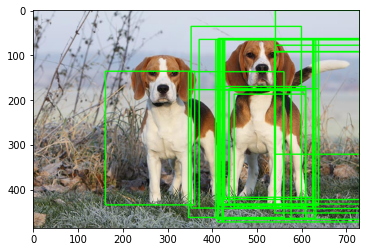

In [22]:
plt.imshow(cv2.cvtColor(proposals_imageF2, cv2.COLOR_BGR2RGB))

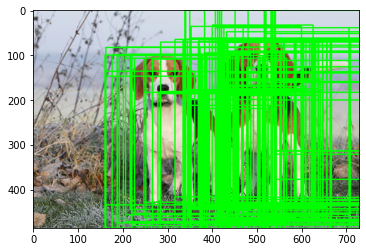

In [23]:
plt.imshow(cv2.cvtColor(proposals_imageQ2, cv2.COLOR_BGR2RGB))

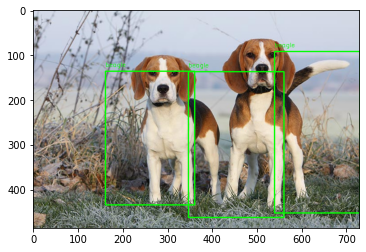

In [24]:
plt.imshow(cv2.cvtColor(annotated_imageF2, cv2.COLOR_BGR2RGB))

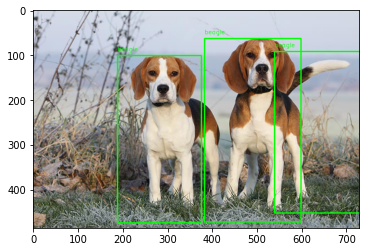

In [25]:
plt.imshow(cv2.cvtColor(annotated_imageQ2, cv2.COLOR_BGR2RGB))

In [26]:
region_graphF, region_graphQ = [], []

def zip_nums(proposals, labels, boxes):
    region_graph = []
    region_graph.append(len(proposals))
    region_graph.append(len(labels[label]))  
    boxes = np.array([p[0] for p in labels[label]])
    proba = np.array([p[1] for p in labels[label]])
    boxes = non_max_suppression(boxes, proba)    
    region_graph.append(len(boxes))
    return region_graph

region_graphF = zip_nums(proposalsF, labelsF, boxesF)
region_graphQ = zip_nums(proposalsQ, labelsQ, boxesQ)
    
print(region_graphF)  
print(region_graphQ)   

[877, 31, 3]
[4173, 245, 3]


In [27]:
#Def bar graph for output of Part C region proposals for evaluating confidence values in range .70 to .99 for fast/quality
def displayData(region_graphF,region_graphQ):
    labels = ['Proposals', 'Labels Proposed', 'Final Predictions']
    x = np.arange(len(labels))
    bar_width = 0.40
    fig, ax = plt.subplots()
    bar_left = ax.bar(x - bar_width / 2, region_graphF, bar_width, label='Fast Search')
    bar_right = ax.bar(x + bar_width / 2, region_graphQ, bar_width, label='Quality Search')
    ax.set_ylabel('Overall Counts')
    ax.set_title('Selective Search - Found Vs. Preposeds Vs. Final Predictions')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    def height_label(bars):                             # quick hight label for graph
        for bar_s in bars:
            height = bar_s.get_height()
            ax.annotate('{}'.format(height),
                        xy=(bar_s.get_x() + bar_s.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')
    height_label(bar_left)
    height_label(bar_right)
    fig.tight_layout()
    plt.show()

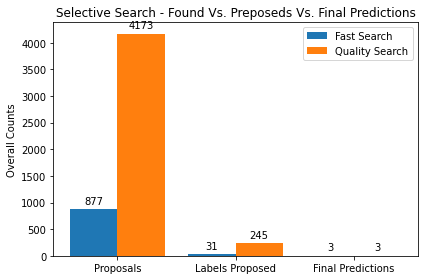

In [28]:
displayData(region_graphF,region_graphQ)

##### Show a graph for the number of region proposals for evaluating confidence values in range .70 to .99 for fast/quality. The graph is the number of reported regions. 



In [29]:
labels_topconf_F = {}
labels_topconf_Q = {}

def pred_made_confidence(preds, confidence, boxes):
    labelFilters = ['beagle']
    L = []    
    # loop over the predictions
    for (i, p) in enumerate(preds):
        # grab the prediction information for the current ROI
        (imagenetID, label, prob) = p[0]
        #print (label)

        # only if the label filters are not empty *and* the label does not
        # exist in the list, then ignore it
        if labelFilters is not None and label not in labelFilters:
            continue
        # filter out weak detections by ensuring the predicted probability
        # is greater than the minimum probability
        if  prob > confidence:
            pass

            L.append((prob))            
    return L
# Define 0.7 for bottom parameter, no 100% find was made in testing so .99 was not needed to define
argsF['conf']=0.7
argsQ['conf']=0.7

labels_topconf_F = pred_made_confidence(predsF, argsF['conf'], boxesF)
labels_topconf_Q = pred_made_confidence(predsQ, argsQ['conf'],boxesQ)

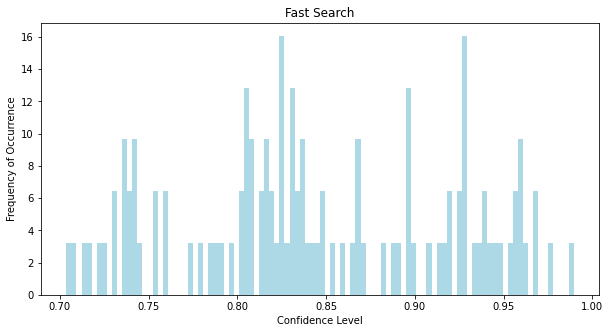

In [30]:
plt.figure(figsize=(10,5))
plt.title('Fast Search')
plt.ylabel('Frequency of Occurrence')
plt.xlabel('Confidence Level')
plt.hist(labels_topconf_F, 100, density =True, color = 'lightblue')
plt.show()

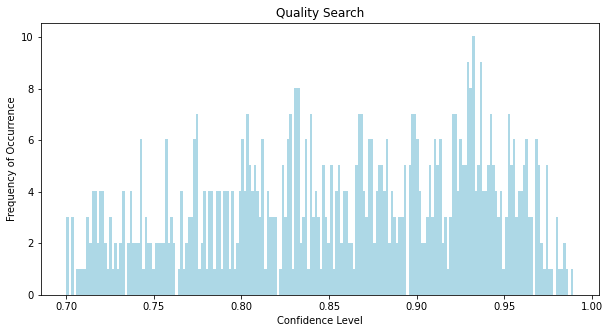

In [31]:
plt.figure(figsize=(10,5))
plt.title('Quality Search')
plt.ylabel('Frequency of Occurrence')
plt.xlabel('Confidence Level')
plt.hist(labels_topconf_Q, 200, density =True, color = 'lightblue')
plt.show()

######  Before NMS, evaluate using IOU techniques, show a percentage of regions for the selective search algorithm for fast setting, that are critical according to (IOU). To be determine critical, these are regions that never overlap with any other region by more than 25%  

In [35]:
# Def iou for intersection
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    return_crit = []
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea) 
    if 0<iou <= 0.25:      # Checkcritical regions that never overlap with any other region by more than 25%                               
        return_crit.append(iou)
        return_crit.append(boxA)
        return_crit.append(boxB)
        #print(return_crit)
        return return_crit 
    
# Def iou query to grab rois and push to main 
def run_iou_query(labels):
    # loop over the labels for each of detected objects in the image
    for label in labels.keys():
        # extract the bounding boxes and associated prediction
        # probabilities, then apply non-maxima suppression
        boxes = np.array([p[0] for p in labels[label]])        
    return boxes
  
temp= []    # Set temp var to grab output from bb_intersection_over_union
crit_iou = [] # Set var to run in program outside of nested FOR
boxes_iou = run_iou_query(labelsF)
for i in range (len(boxes_iou)):
    for j in range(len(boxes_iou)):
        temp = bb_intersection_over_union(boxes_iou[i],boxes_iou[j])
        crit_iou.append(temp)

Not_none_values = filter(None.__ne__, crit_iou)
crit_iou = list(Not_none_values)

print(len(crit_iou))
type(crit_iou)


172


list

In [34]:
pp = pprint.PrettyPrinter(indent=3)
pp.pprint(crit_iou)

[  [  0.17630360902374212,
      array([407,  65, 626, 464], dtype=int32),
      array([540,   0, 729, 321], dtype=int32)],
   [  0.18763921790474844,
      array([407,  65, 626, 464], dtype=int32),
      array([540,  78, 729, 321], dtype=int32)],
   [  0.23610752132333937,
      array([407,  65, 626, 464], dtype=int32),
      array([540,   0, 729, 442], dtype=int32)],
   [  0.17854230331490228,
      array([407,  65, 626, 464], dtype=int32),
      array([540,  93, 729, 321], dtype=int32)],
   [  0.17630360902374212,
      array([540,   0, 729, 321], dtype=int32),
      array([407,  65, 626, 464], dtype=int32)],
   [  0.09384505034547254,
      array([540,   0, 729, 321], dtype=int32),
      array([407, 170, 607, 464], dtype=int32)],
   [  0.19134226760263773,
      array([540,   0, 729, 321], dtype=int32),
      array([425,  65, 623, 432], dtype=int32)],
   [  0.0253893650354806,
      array([540,   0, 729, 321], dtype=int32),
      array([370, 177, 558, 441], dtype=int32)],
   [  0.1

###### We can see from the output about that there are alot of inverse critical bounding boxes that coincide with one another. Looking at the likeness of all bounding boxes the assumption of Qty ~30 bounding boxes are critical in the picture.


###### Plot/find the execution time for model.predict(proposals) for the fast versus quality setting of region proposals.

In [36]:
print("[INFO] classifying fast proposals...")
e1F_partF = cv2.getTickCount()
predsF = model.predict(proposalsF)
e2F_partF = cv2.getTickCount()

print("[INFO] classifying quality proposals...")
e1Q_partF = cv2.getTickCount()
predsQ = model.predict(proposalsQ)
e2Q_partF = cv2.getTickCount()

timeF__partF = (e2F_partF - e1F_partF)/ cv2.getTickFrequency()
timeQ__partF = (e2Q_partF - e1Q_partF)/ cv2.getTickFrequency()

print("For Fast proposals")
print(timeF__partF, "seconds\n")

print("For Quality proposals")
print(timeQ__partF, "seconds\n")

[INFO] classifying fast proposals...
[INFO] classifying quality proposals...
For Fast proposals
9.838739171 seconds

For Quality proposals
46.174446118 seconds



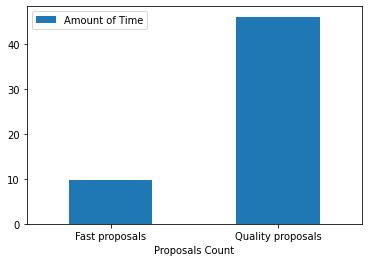

In [37]:
df = pd.DataFrame({'Proposals Count':['Fast proposals', 'Quality proposals'], 'Amount of Time':[timeF__partF, timeQ__partF]})
ax = df.plot.bar(x='Proposals Count', y='Amount of Time', rot=0)